In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten, Dense
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train_16000.csv', )
train = train.drop(['Unnamed: 0'], axis=1)
train.head(5)

,image,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.3225,88.245,184.4820,88.5780,183.6495,115.551,184.4820,138.8610,183.4830,...,177.489,39.96,179.4870,37.9620,175.1580,38.1285,183.3165,40.959,171.4950,41.2920
1,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,176.8230,87.912,184.3155,87.9120,183.6495,115.551,184.1490,140.6925,183.4830,...,177.489,39.96,179.8200,37.9620,175.1580,38.2950,183.3165,40.959,171.9945,41.2920
2,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.8220,88.578,183.9825,88.4115,183.6495,115.551,184.1490,141.1920,183.3165,...,177.489,39.96,179.6535,38.1285,174.9915,38.1285,183.3165,40.959,171.9945,41.4585
3,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.8220,88.578,184.6485,88.5780,183.6495,115.551,184.1490,140.1930,183.3165,...,177.489,39.96,179.4870,38.1285,174.9915,38.2950,183.3165,40.959,171.8280,41.2920
4,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.8220,88.578,183.9825,88.5780,183.6495,115.551,183.6495,139.6935,183.6495,...,177.489,39.96,179.8200,38.1285,174.9915,38.4615,183.3165,40.959,172.1610,41.2920


In [3]:
train_paths = list(train['image'])

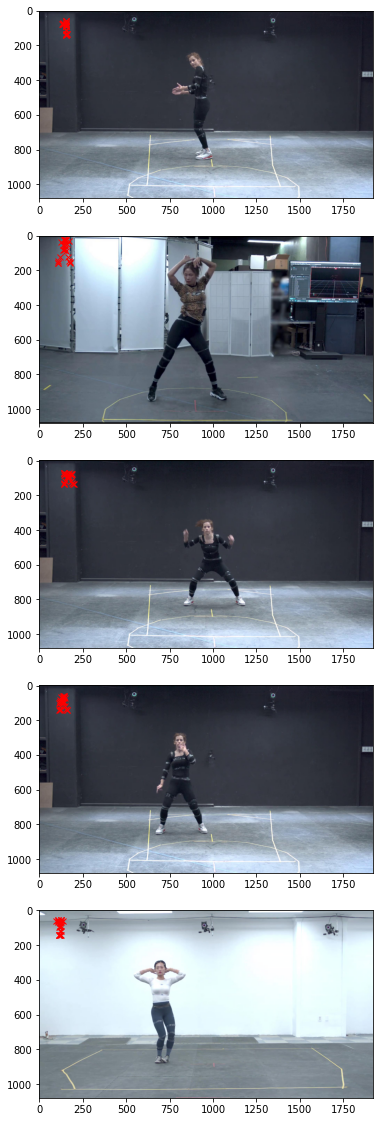

In [4]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = train_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = train.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1

In [5]:
def trainGenerator():
    for i in range(len(train)):
        img = tf.io.read_file(train['image'][i]) # path(경로)를 통해 이미지 읽기
        img = tf.image.decode_jpeg(img, channels=3) # 경로를 통해 불러온 이미지를 tensor로 변환
        img = tf.image.resize(img, [180,320]) # 이미지 resize 
        target = train.iloc[:,1:59].iloc[i,:] # keypoint 뽑아주기
        
        yield (img, target)

#generator를 활용해 데이터셋 만들기        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([180,320,3]),tf.TensorShape([58])))
train_dataset = train_dataset.batch(32).prefetch(1)

In [6]:
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Activation, Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [7]:
#간단한 CNN 모델을 적용합니다.

model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(180,320,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(58))

In [8]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [9]:
model.fit(train_dataset,epochs = 15, verbose=1)

Epoch 1/15
500/500 [==============================] - 3471s 7s/step - loss: 627.6122 - mae: 18.3335
Epoch 2/15
500/500 [==============================] - 3450s 7s/step - loss: 370.6911 - mae: 14.6494
Epoch 3/15
500/500 [==============================] - 3492s 7s/step - loss: 262.6887 - mae: 12.1381
Epoch 4/15
500/500 [==============================] - 3476s 7s/step - loss: 226.7058 - mae: 11.2124
Epoch 5/15
500/500 [==============================] - 3447s 7s/step - loss: 216.6309 - mae: 10.8846
Epoch 6/15
500/500 [==============================] - 3456s 7s/step - loss: 211.0049 - mae: 10.7505
Epoch 7/15
500/500 [==============================] - 3452s 7s/step - loss: 181.2081 - mae: 9.9025
Epoch 8/15
500/500 [==============================] - 3449s 7s/step - loss: 171.9702 - mae: 9.7068
Epoch 9/15
500/500 [==============================] - 3445s 7s/step - loss: 152.8264 - mae: 9.1156
Epoch 10/15
500/500 [==============================] - 3419s 7s/step - loss: 153.3731 - mae: 9.1762
Epo

In [10]:
from keras.models import load_model

model.save('data_16000_epoch_15')  # creates a HDF5 file 'my_model.h5'

INFO:tensorflow:Assets written to: data_16000_epoch_15\assets


In [11]:
from keras.models import load_model

model.save('data_16000_epoch_15')  # creates a HDF5 file 'my_model.h5'

INFO:tensorflow:Assets written to: data_16000_epoch_15\assets


In [12]:
test = pd.read_csv('original_test.csv', )
test = test.drop(['Unnamed: 0'], axis=1)
test = test[:200]
test

,image,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,916,560,964,558,940,771,930,926,918,...,923,241,939,222,904,223,966,237,877,234
1,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,916,560,964,560,940,771,930,926,918,...,923,241,939,222,904,223,966,237,882,240
2,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,916,560,964,560,940,777,930,921,918,...,923,241,939,222,904,223,966,237,882,240
3,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,916,560,964,560,940,777,930,921,918,...,923,241,939,222,904,223,966,237,882,240
4,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,916,560,964,560,940,777,930,921,918,...,923,241,939,222,904,223,966,237,882,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,920,560,970,559,938,770,929,933,912,...,934,257,953,236,920,234,974,239,887,236
196,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,920,561,965,559,938,773,928,936,914,...,934,254,952,236,920,235,975,242,886,235
197,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,914,565,968,558,938,770,930,934,913,...,936,258,952,240,919,235,974,242,888,236
198,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,920,561,971,559,938,770,929,941,913,...,931,255,952,236,919,235,973,240,886,235


In [13]:
test_paths = test['image']

In [14]:
X_test=[]

for test_path in tqdm(test_paths):
    img=tf.io.read_file(test_path)
    img=tf.image.decode_jpeg(img, channels=3)
    img=tf.image.resize(img, [180,320])
    X_test.append(img)

100%|██████████| 200/200 [00:06<00:00, 30.79it/s]


In [15]:
X_test=tf.stack(X_test, axis=0)
X_test.shape

TensorShape([200, 180, 320, 3])

In [27]:
pred=model.predict(X_test)

In [33]:
predict = pd.DataFrame(pred, columns = ["center_hip_x", "center_hip_y", "left_hip_x", "left_hip_y", "left_knee_x", "left_knee_y", "left_ankle_x", "left_ankle_y", "left_bigtoe_X", "left_bigtoe_y",
                "left_littletoe_x", "left_littletoe_y", "right_hip_x", "right_hip_y", "right_knee_x", "right_knee_y", "right_ankle_x", "right_ankle_y", "right_bigtoe_x", "right_bigtoe_y",
                "right_littletoe_x", "right_littletoe_y", "navel_x", "navel_y", "chest_x", "chest_y", "neck_x", "neck_y", "left_shoulder_x", "left_shoulder_y", "left_elbow_x", "left_elbow_y",
                "left_wrist_x", "left_wrist_y", "left_palm_thumb_x", "left_palm_thumb_y", "left_palm_pinky_x", "left_palm_pinky_y", "right_shoulder_x", "right_shoulder_y", "right_elbow_x", "right_elbow_y",
                "right_wrist_x", "right_wrist_y", "right_palm_thumb_x", "right_palm_thumb_y", "right_palm_pinky_x", "right_palm_pinky_y", "nose_x", "nose_y", "left_eye_x", "left_eye_y",
                "right_eye_x", "right_eye_y", "left_ear_x", "left_ear_y", "right_ear_x", "right_ear_y"])

predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,115.514687,66.201836,120.740219,66.717773,117.938438,86.848000,122.981827,99.988457,121.596809,107.156166,...,115.509430,33.104671,116.118103,31.712061,114.599182,31.871653,119.079620,33.864044,112.390656,33.370975
1,115.781250,66.324471,121.027718,66.841553,118.215668,87.025696,123.269272,100.195526,121.878143,107.380287,...,115.774490,33.150051,116.385056,31.755758,114.864792,31.916733,119.357376,33.913628,112.649940,33.420033
2,115.316093,66.096024,120.541283,66.611099,117.743248,86.720512,122.770256,99.849777,121.387978,107.008217,...,115.308334,33.042545,115.917900,31.652706,114.398079,31.812363,118.876686,33.802452,112.187653,33.312302
3,115.500504,66.191902,120.739449,66.707535,117.935738,86.840340,122.975021,99.984833,121.592140,107.155151,...,115.491631,33.087719,116.102715,31.696661,114.584457,31.859364,119.071075,33.850044,112.369125,33.363415
4,115.568924,66.035904,120.717453,66.549591,117.909492,86.566124,123.019508,99.599579,121.616402,106.737846,...,115.570229,33.057903,116.168961,31.668373,114.689796,31.828484,119.122360,33.807491,112.537254,33.302071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,111.170044,67.394073,115.701912,67.854584,115.312355,85.888954,120.142250,98.516083,119.579140,105.147903,...,111.260948,36.216366,112.017136,34.810242,110.201935,34.921638,114.804352,36.705559,108.275421,36.322170
196,111.281891,67.430374,115.814819,67.890976,115.397369,85.946953,120.235931,98.582809,119.663399,105.223228,...,111.372490,36.219948,112.126816,34.812340,110.313957,34.923702,114.915863,36.710304,108.385971,36.324623
197,111.162582,67.415733,115.694145,67.875458,115.273659,85.909676,120.105568,98.540504,119.538597,105.178986,...,111.256790,36.222176,112.010666,34.814011,110.196877,34.925632,114.797668,36.710632,108.263992,36.327477
198,110.924477,67.313560,115.451271,67.772179,115.029945,85.754570,119.852364,98.354408,119.289352,104.980843,...,111.019531,36.183273,111.772797,34.777321,109.960602,34.889114,114.557175,36.670563,108.028671,36.289318


In [34]:
# 좌표값에 6곱하기
predict = predict * 8
predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,924.117493,529.614685,965.921753,533.742188,943.507507,694.783997,983.854614,799.907654,972.774475,857.249329,...,924.075439,264.837372,928.944824,253.696487,916.793457,254.973221,952.636963,270.912354,899.125244,266.967804
1,926.250000,530.595764,968.221741,534.732422,945.725342,696.205566,986.154175,801.564209,975.025146,859.042297,...,926.195923,265.200409,931.080444,254.046066,918.918335,255.333862,954.859009,271.309021,901.199524,267.360260
2,922.528748,528.768188,964.330261,532.888794,941.945984,693.764099,982.162048,798.798218,971.103821,856.065735,...,922.466675,264.340363,927.343201,253.221649,915.184631,254.498901,951.013489,270.419617,897.501221,266.498413
3,924.004028,529.535217,965.915588,533.660278,943.485901,694.722717,983.800171,799.878662,972.737122,857.241211,...,923.933044,264.701752,928.821716,253.573288,916.675659,254.874908,952.568604,270.800354,898.953003,266.907318
4,924.551392,528.287231,965.739624,532.396729,943.275940,692.528992,984.156067,796.796631,972.931213,853.902771,...,924.561829,264.463226,929.351685,253.346985,917.518372,254.627869,952.978882,270.459930,900.298035,266.416565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,889.360352,539.152588,925.615295,542.836670,922.498840,687.111633,961.138000,788.128662,956.633118,841.183228,...,890.087585,289.730927,896.137085,278.481934,881.615479,279.373108,918.434814,293.644470,866.203369,290.577362
196,890.255127,539.442993,926.518555,543.127808,923.178955,687.575623,961.887451,788.662476,957.307190,841.785828,...,890.979919,289.759583,897.014526,278.498718,882.511658,279.389618,919.326904,293.682434,867.087769,290.596985
197,889.300659,539.325867,925.553162,543.003662,922.189270,687.277405,960.844543,788.324036,956.308777,841.431885,...,890.054321,289.777405,896.085327,278.512085,881.575012,279.405060,918.381348,293.685059,866.111938,290.619812
198,887.395813,538.508484,923.610168,542.177429,920.239563,686.036560,958.818909,786.835266,954.314819,839.846741,...,888.156250,289.466187,894.182373,278.218567,879.684814,279.112915,916.457397,293.364502,864.229370,290.314545


In [29]:
# 좌표값에 6곱하기
predict = predict * 7.5
predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,866.360168,496.513763,905.551636,500.383301,884.538269,651.359985,922.363708,749.913452,911.976074,803.671265,...,866.320740,248.285034,870.885742,237.840454,859.493896,239.037399,893.097168,253.980331,842.929932,250.282318
1,868.359375,497.433533,907.707886,501.311646,886.617493,652.692749,924.519531,751.466431,914.086060,805.352173,...,868.308655,248.625381,872.887939,238.168182,861.485962,239.375488,895.180298,254.352203,844.874573,250.650238
2,864.870728,495.720184,904.059631,499.583252,883.074341,650.403870,920.776917,748.873352,910.409851,802.561646,...,864.812500,247.819092,869.384277,237.395294,857.985596,238.592712,891.575134,253.518387,841.407410,249.842255
3,866.253784,496.439270,905.545837,500.306519,884.518005,651.302551,922.312683,749.886230,911.941040,803.663635,...,866.187256,248.157898,870.770386,237.724960,859.383423,238.945221,893.033081,253.875336,842.768433,250.225616
4,866.766907,495.269287,905.380920,499.121948,884.321167,649.245911,922.646301,746.996826,912.122986,800.533875,...,866.776733,247.934280,871.267212,237.512802,860.173462,238.713623,893.417725,253.556183,844.029419,249.765533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,833.775330,505.455566,867.764343,508.909363,864.842651,644.167175,901.066895,738.870605,896.843567,788.609253,...,834.457092,271.622742,840.128540,261.076813,826.514526,261.912292,861.032654,275.291687,812.065674,272.416290
196,834.614197,505.727814,868.611145,509.182312,865.480286,644.602173,901.769470,739.371094,897.475464,789.174194,...,835.293701,271.649597,840.951111,261.092560,827.354675,261.927765,861.868958,275.327271,812.894775,272.434662
197,833.719360,505.618011,867.706116,509.065918,864.552429,644.322571,900.791748,739.053772,896.539490,788.842407,...,834.425903,271.666321,840.080017,261.105072,826.476562,261.942230,860.982544,275.329742,811.979919,272.456085
198,831.933594,504.851715,865.884521,508.291351,862.724609,643.159302,898.892700,737.658081,894.670166,787.356323,...,832.646484,271.374542,838.295959,260.829895,824.704529,261.668365,859.178833,275.029236,810.215027,272.169891


In [22]:
# 좌표값에 6곱하기
predict = predict * 4
predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,462.058746,264.807343,482.960876,266.871094,471.753754,347.391998,491.927307,399.953827,486.387238,428.624664,...,462.037720,132.418686,464.472412,126.848244,458.396729,127.486610,476.318481,135.456177,449.562622,133.483902
1,463.125000,265.297882,484.110870,267.366211,472.862671,348.102783,493.077087,400.782104,487.512573,429.521149,...,463.097961,132.600204,465.540222,127.023033,459.459167,127.666931,477.429504,135.654510,450.599762,133.680130
2,461.264374,264.384094,482.165131,266.444397,470.972992,346.882050,491.081024,399.399109,485.551910,428.032867,...,461.233337,132.170181,463.671600,126.610825,457.592316,127.249451,475.506744,135.209808,448.750610,133.249207
3,462.002014,264.767609,482.957794,266.830139,471.742950,347.361359,491.900085,399.939331,486.368561,428.620605,...,461.966522,132.350876,464.410858,126.786644,458.337830,127.437454,476.284302,135.400177,449.476501,133.453659
4,462.275696,264.143616,482.869812,266.198364,471.637970,346.264496,492.078033,398.398315,486.465607,426.951385,...,462.280914,132.231613,464.675842,126.673492,458.759186,127.313934,476.489441,135.229965,450.149017,133.208282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,444.680176,269.576294,462.807648,271.418335,461.249420,343.555817,480.569000,394.064331,478.316559,420.591614,...,445.043793,144.865463,448.068542,139.240967,440.807739,139.686554,459.217407,146.822235,433.101685,145.288681
196,445.127563,269.721497,463.259277,271.563904,461.589478,343.787811,480.943726,394.331238,478.653595,420.892914,...,445.489960,144.879791,448.507263,139.249359,441.255829,139.694809,459.663452,146.841217,433.543884,145.298492
197,444.650330,269.662933,462.776581,271.501831,461.094635,343.638702,480.422272,394.162018,478.154388,420.715942,...,445.027161,144.888702,448.042664,139.256042,440.787506,139.702530,459.190674,146.842529,433.055969,145.309906
198,443.697906,269.254242,461.805084,271.088715,460.119781,343.018280,479.409454,393.417633,477.157410,419.923370,...,444.078125,144.733093,447.091187,139.109283,439.842407,139.556458,458.228699,146.682251,432.114685,145.157272


In [35]:
my_test = pd.concat([test['image'], predict], axis=1)

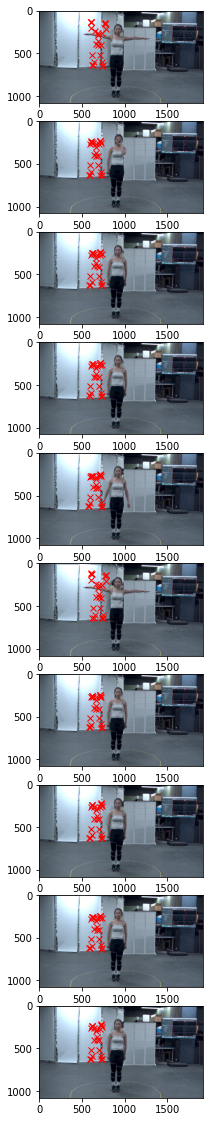

In [20]:
# 학습시킬 때 좌표값에 1/6했으니 테스할때 다시 6곱해준 것
# 테스트

plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(test_paths),10):
    
    plt.subplot(10,1, count)
    
    img_sample_path = test_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = my_test.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count+=1
    

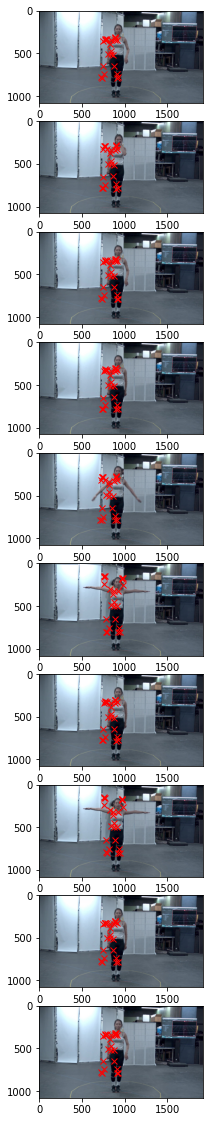

In [32]:
# 좌표갑에 7.5곱한것(그냥 추측성)
# 테스트

plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(test_paths),10):
    
    plt.subplot(10,1, count)
    
    img_sample_path = test_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = my_test.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1

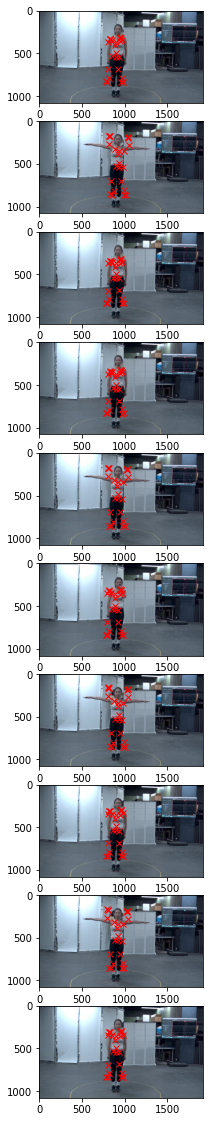

In [36]:
# 좌표갑에 8곱한것(그냥 추측성)
# 테스트

plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(test_paths),10):
    
    plt.subplot(10,1, count)
    
    img_sample_path = test_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = my_test.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1